In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

from math import sqrt

plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 12


# Анализ Babyboom — проверка нормальности, экспоненциальности и пуассона

Задачи:
- Проверить нормальность распределения веса при рождении (все дети вместе и отдельно для девочек/мальчиков).
- Построить точечные оценки (среднее, дисперсия) и доверительные интервалы для параметров нормального распределения (среднего и σ).
- Проверить, подчиняются ли интервалы между рождениями экспоненциальному закону (оценка параметра по выборочному среднему), тест КС.
- Проверить, распределено ли число рождений по часам как пуассоновское (оценка λ по среднему числу рождений в час), χ²-тест согласия.


In [16]:
babyboomDataFrame = pd.read_csv(
    'babyboom.dat.txt',
    sep='\s+',
    header=None,
    names=['timeOfBirth24', 'sexCode', 'birthWeightGrams', 'minutesAfterMidnight']
)

babyboomDataFrame['sexCode'] = babyboomDataFrame['sexCode'].astype(int)
babyboomDataFrame['birthWeightGrams'] = pd.to_numeric(babyboomDataFrame['birthWeightGrams'], errors='coerce')
babyboomDataFrame['minutesAfterMidnight'] = pd.to_numeric(babyboomDataFrame['minutesAfterMidnight'], errors='coerce')

print('Размер выборки babyboom:', len(babyboomDataFrame))
babyboomDataFrame.head()


Размер выборки babyboom: 44


,timeOfBirth24,sexCode,birthWeightGrams,minutesAfterMidnight
0,5,1,3837,5
1,104,1,3334,64
2,118,2,3554,78
3,155,2,3838,115
4,257,2,3625,177


N = 44
Среднее (точечная оценка): 3275.9545454545455
Выборочная дисперсия (точечная оценка): 278818.27695560263
Выборочное SD: 528.0324582405921
Shapiro-Wilk: statistic = 0.8987 , p-value = 0.000994
Anderson-Darling statistic = 1.7168
Критические значения (обычно 15%, 10%, 5%, 2.5%, 1%): [0.534 0.609 0.73  0.852 1.013]
Соответствующие уровни: [15.  10.   5.   2.5  1. ]
Kolmogorov-Smirnov (с подогнанными параметрами): statistic = 0.1834 , p-value = 0.091065


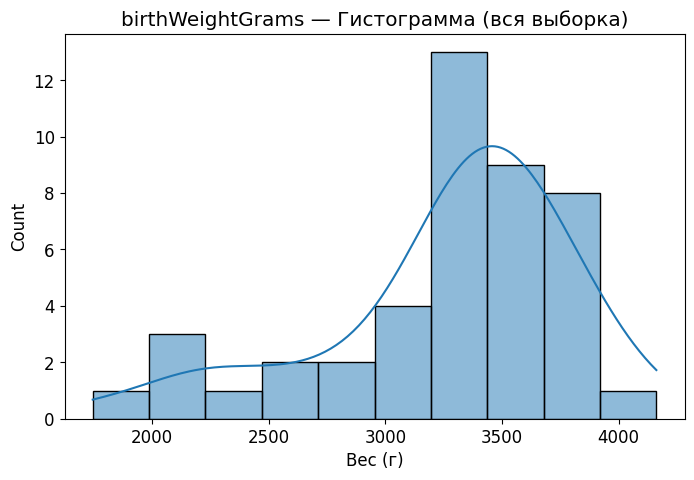

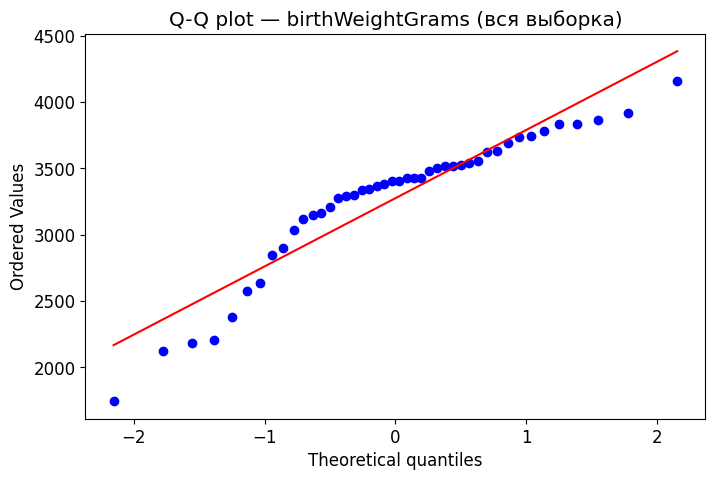

In [17]:
# 1) Нормальность веса: вся выборка
birthWeightSeries = babyboomDataFrame['birthWeightGrams'].dropna()
nSample = birthWeightSeries.size
meanWeight = birthWeightSeries.mean()
varWeight = birthWeightSeries.var(ddof=1)
sdWeight = birthWeightSeries.std(ddof=1)

print('N =', nSample)
print('Среднее (точечная оценка):', meanWeight)
print('Выборочная дисперсия (точечная оценка):', varWeight)
print('Выборочное SD:', sdWeight)

# Гистограмма и Q-Q
plt.figure()
sns.histplot(birthWeightSeries, kde=True)
plt.title('birthWeightGrams — Гистограмма (вся выборка)')
plt.xlabel('Вес (г)')

plt.figure()
sps.probplot(birthWeightSeries, dist='norm', plot=plt)
plt.title('Q-Q plot — birthWeightGrams (вся выборка)')

# Шапиро-Уилк
shapiroStatistic, shapiroPvalue = sps.shapiro(birthWeightSeries)
print('Shapiro-Wilk: statistic =', round(shapiroStatistic,4), ', p-value =', round(shapiroPvalue,6))

# Anderson-Darling
andersonResult = sps.anderson(birthWeightSeries, dist='norm')
print('Anderson-Darling statistic =', round(andersonResult.statistic,4))
print('Критические значения (обычно 15%, 10%, 5%, 2.5%, 1%):', andersonResult.critical_values)
print('Соответствующие уровни:', andersonResult.significance_level)

# KS тест
ksStatistic, ksPvalue = sps.kstest(birthWeightSeries, 'norm', args=(meanWeight, sdWeight))
print('Kolmogorov-Smirnov (с подогнанными параметрами): statistic =', round(ksStatistic,4), ', p-value =', round(ksPvalue,6))

---- Girls ----
N = 18 Mean = 3132.4444444444443 SD = 631.582533586883
Shapiro-Wilk: statistic = 0.8703 , p-value = 0.017985
KS (with fitted mean/sd): statistic = 0.2143 , p-value = 0.331584
---- Boys ----
N = 26 Mean = 3375.3076923076924 SD = 428.0460507217203
Shapiro-Wilk: statistic = 0.9475 , p-value = 0.202248
KS (with fitted mean/sd): statistic = 0.1554 , p-value = 0.507076


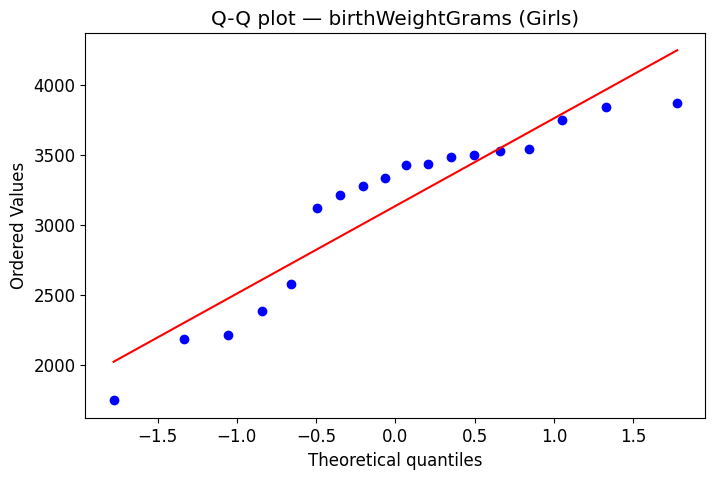

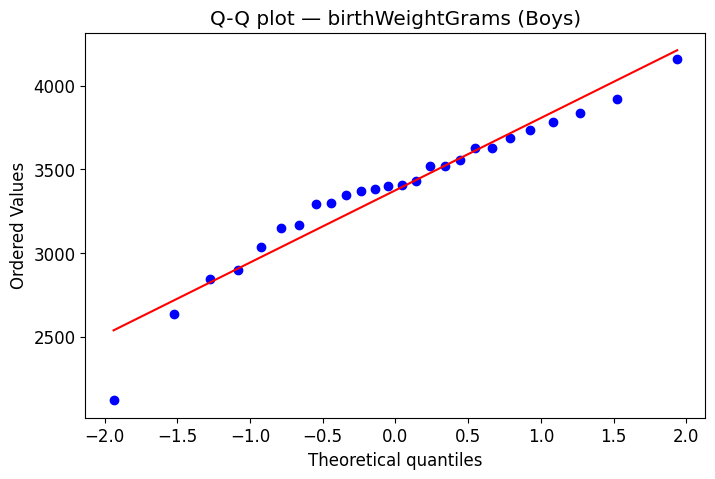

In [18]:
# 2) Нормальность веса по полу (1 = girl, 2 = boy)
for sexCode, sexLabel in [(1, 'Girls'), (2, 'Boys')]:
    subsetSeries = babyboomDataFrame.loc[babyboomDataFrame['sexCode']==sexCode, 'birthWeightGrams'].dropna()
    nSubset = subsetSeries.size
    meanSubset = subsetSeries.mean()
    sdSubset = subsetSeries.std(ddof=1)
    print('----', sexLabel, '----')
    print('N =', nSubset, 'Mean =', meanSubset, 'SD =', sdSubset)
    
    # Shapiro
    if nSubset >= 3:
        shapiroStatisticSub, shapiroPvalueSub = sps.shapiro(subsetSeries)
        print('Shapiro-Wilk: statistic =', round(shapiroStatisticSub,4), ', p-value =', round(shapiroPvalueSub,6))
    else:
        print('Shapiro test: sample too small')
    
    # KS с параметрами
    ksStatisticSub, ksPvalueSub = sps.kstest(subsetSeries, 'norm', args=(meanSubset, sdSubset))
    print('KS (with fitted mean/sd): statistic =', round(ksStatisticSub,4), ', p-value =', round(ksPvalueSub,6))
    
    # QQ plot
    plt.figure()
    sps.probplot(subsetSeries, dist='norm', plot=plt)
    plt.title(f'Q-Q plot — birthWeightGrams ({sexLabel})')


In [19]:
# 3) Доверительные интервалы для параметров нормального распределения (для всей выборки и по полу)
def confidenceIntervalForMean(sampleSeries, confidenceLevel=0.95):
    n = sampleSeries.size
    meanValue = sampleSeries.mean()
    sdValue = sampleSeries.std(ddof=1)
    alpha = 1 - confidenceLevel
    tCritical = sps.t.ppf(1 - alpha/2, df=n-1)
    marginError = tCritical * sdValue / sqrt(n)
    return meanValue - marginError, meanValue + marginError

def confidenceIntervalForSigma(sampleSeries, confidenceLevel=0.95):
    # CI для σ при нормальности через хи-квадрат
    n = sampleSeries.size
    sampleVariance = sampleSeries.var(ddof=1)
    alpha = 1 - confidenceLevel
    chi2Lower = sps.chi2.ppf(alpha/2, df=n-1)
    chi2Upper = sps.chi2.ppf(1 - alpha/2, df=n-1)
    lowerSigma = sqrt((n-1) * sampleVariance / chi2Upper)
    upperSigma = sqrt((n-1) * sampleVariance / chi2Lower)
    return lowerSigma, upperSigma

print('=== Вся выборка ===')
print('CI mean (95%):', confidenceIntervalForMean(birthWeightSeries, 0.95))
print('CI sigma (95%):', confidenceIntervalForSigma(birthWeightSeries, 0.95))

for sexCode, sexLabel in [(1,'Girls'), (2,'Boys')]:
    subsetSeries = babyboomDataFrame.loc[babyboomDataFrame['sexCode']==sexCode, 'birthWeightGrams'].dropna()
    if subsetSeries.size >= 2:
        print(f'=== {sexLabel} ===')
        print('CI mean (95%):', confidenceIntervalForMean(subsetSeries, 0.95))
        print('CI sigma (95%):', confidenceIntervalForSigma(subsetSeries, 0.95))
    else:
        print(f'{sexLabel}: недостаточно данных для CI')

=== Вся выборка ===
CI mean (95%): (3115.418005028038, 3436.491085881053)
CI sigma (95%): (436.27247886430507, 669.0306102925874)
=== Girls ===
CI mean (95%): (2818.3658395570424, 3446.5230493318463)
CI sigma (95%): (473.93169852283967, 946.8331595131432)
=== Boys ===
CI mean (95%): (3202.4161508132743, 3548.1992338021105)
CI sigma (95%): (335.69825689250627, 590.878537222306)


## Проверка экспоненциального распределения интервалов между рождениями
Подход:
- Отсортируем рождение по времени (minutesAfterMidnight) и вычислим разности последовательных времен — это интервалы (в минутах).
- Оценка параметра экспоненциального распределения λ = 1/meanInterval (точечная оценка).
- Тестируем гипотезу H0: интервалы ~ Exponential(scale = 1/λ) с помощью теста Колмогорова–Смирнова (kstest) с подставленным параметром масштаба = средний интервал.


N intervals = 43
Mean interval (мин): 33.25581395348837
MLE lambda (1/mean): 0.03006993006993007
KS test vs Exponential(loc=0, scale=meanInterval): statistic = 0.1375 , p-value = 0.357427


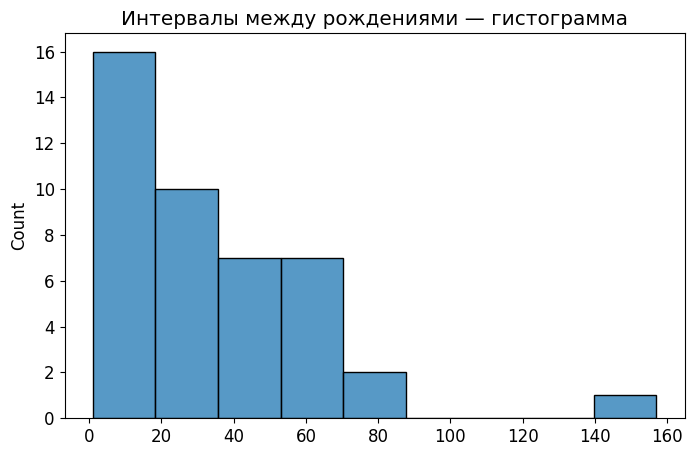

In [20]:
# Вычислим интервалы между рождениями (в минутах)
sortedMinutes = babyboomDataFrame['minutesAfterMidnight'].dropna().sort_values().values
intervalsBetweenBirths = np.diff(sortedMinutes)
intervalsBetweenBirths = intervalsBetweenBirths[intervalsBetweenBirths > 0]
nIntervals = intervalsBetweenBirths.size
meanInterval = intervalsBetweenBirths.mean()
lambdaEstimate = 1.0 / meanInterval if meanInterval > 0 else np.nan

print('N intervals =', nIntervals)
print('Mean interval (мин):', meanInterval)
print('MLE lambda (1/mean):', lambdaEstimate)

# Гистограмма и Q-Q для экспоненциального распределения
plt.figure()
sns.histplot(intervalsBetweenBirths, kde=False)
plt.title('Интервалы между рождениями — гистограмма')

# KS test: сравним данные с экспоненциальным с scale=meanInterval (loc=0)
ksStatisticExp, ksPvalueExp = sps.kstest(intervalsBetweenBirths, 'expon', args=(0, meanInterval))
print('KS test vs Exponential(loc=0, scale=meanInterval): statistic =', round(ksStatisticExp,4), ', p-value =', round(ksPvalueExp,6))


## Проверка пуассоновского распределения числа рождений по часам
Подход:
- Для каждого часа (0..23) посчитаем число рождений в этот час.
- Оценка λ (для пуассона) — среднее число рождений в час (точечная оценка).
- Применим χ²-тест согласия: сравним наблюдаемые частоты по часам с ожидаемыми частотами от распределения Пуассона (pmf для 0,1,2,...), но поскольку у нас дискретный счёт по часам и значения (количество в час) — мы сравним распределение количества рождений за часы с пуассоновским распределением целиком.


In [21]:
# Подсчёт числа рождений по часам
minutesSeries = babyboomDataFrame['minutesAfterMidnight'].dropna().astype(int)
hoursSeries = (minutesSeries // 60) % 24
countsByHour = hoursSeries.value_counts().sort_index().reindex(range(24), fill_value=0)
totalHours = countsByHour.size

# Распределение количества рождений в час: для k=0,1,2,...
countsOfCounts = pd.Series(countsByHour.values).value_counts().sort_index()
maxObserved = int(countsOfCounts.index.max())
meanPerHour = countsByHour.mean()
lambdaPoisson = meanPerHour

# Построим observed и expected для k=0..kMax
kMax = maxObserved + 5
observedFrequencies = np.array([ int(countsOfCounts.get(k, 0)) for k in range(0, kMax+1) ])
expectedProbs = np.array([ sps.poisson.pmf(k, mu=lambdaPoisson) for k in range(0, kMax+1) ])

# Нормализация/коррекция: ожидаемые частоты
expectedFrequencies = expectedProbs * totalHours

# Если суммарно ожидаемых ≠ totalHours из-за усечения/плюс-минус, поправим последнюю ячейку:
diffSum = totalHours - expectedFrequencies.sum()
expectedFrequencies[-1] += diffSum
print('diffSum =', diffSum)

# Теперь объединим хвосты, где expected < 5 (если нужно)
maskSmall = expectedFrequencies < 5
if maskSmall.any():
    keepIndices = [i for i in range(len(expectedFrequencies)) if not maskSmall[i]]
    collapsedObserved = list(observedFrequencies[keepIndices])
    collapsedExpected = list(expectedFrequencies[keepIndices])
    collapsedObserved.append(int(observedFrequencies[maskSmall].sum()))
    collapsedExpected.append(expectedFrequencies[maskSmall].sum())
else:
    collapsedObserved = observedFrequencies
    collapsedExpected = expectedFrequencies

collapsedObserved = np.array(collapsedObserved, dtype=float)
collapsedExpected = np.array(collapsedExpected, dtype=float)

# Учтём, что параметр λ оценён по данным => df уменьшится на 1: ddof=1
chi2Statistic, chi2Pvalue = sps.chisquare(f_obs=collapsedObserved, f_exp=collapsedExpected, ddof=1)
print('Chi-square statistic =', chi2Statistic, ', p-value =', chi2Pvalue)

ksStatisticInformal, ksPvalueInformal = sps.kstest(countsByHour.values, 'poisson', args=(lambdaPoisson,))
print('Informal KS statistic =', ksStatisticInformal, ', p-value =', ksPvalueInformal)

diffSum = 0.0005426002740094304
Chi-square statistic = 0.18904359148507408 , p-value = 0.6637138228152089
Informal KS statistic = 0.3279926138924665 , p-value = 0.00843012360162776


# Dataset Euroweight — нормальность веса монет и доверительные интервалы
Задачи:
- Объединить все монеты в одну выборку и проверить нормальность распределения веса.
- Затем проверить нормальность по каждому батчу (batch) отдельно.
- Построить доверительные интервалы для среднего и σ (при условии нормальности).


In [22]:
euroweightDataFrame = pd.read_csv('euroweight.dat.txt', sep='\s+', header=None, names=['index', 'weight', 'batch'])
euroweightDataFrame['weight'] = pd.to_numeric(euroweightDataFrame['weight'], errors='coerce')
euroweightDataFrame['batch'] = euroweightDataFrame['batch'].astype(int)
print('Размер euroweight:', len(euroweightDataFrame))
euroweightDataFrame.head()

# 1) Все монеты вместе
weightAllSeries = euroweightDataFrame['weight'].dropna()
print('=== Все монеты вместе ===')
print('N =', weightAllSeries.size, 'Mean =', weightAllSeries.mean(), 'SD =', weightAllSeries.std(ddof=1))
shapAllStat, shapAllP = sps.shapiro(weightAllSeries)
print('Shapiro-Wilk: statistic =', round(shapAllStat,4), ', p-value =', round(shapAllP,6))
ksAllStat, ksAllP = sps.kstest(weightAllSeries, 'norm', args=(weightAllSeries.mean(), weightAllSeries.std(ddof=1)))
print('KS (fitted): statistic =', round(ksAllStat,4), ', p-value =', round(ksAllP,6))

print('Доверительные интервалы (95%) для всех монет:')
print('CI mean =', confidenceIntervalForMean(weightAllSeries, 0.95))
print('CI sigma =', confidenceIntervalForSigma(weightAllSeries, 0.95))

# 2) По batch'ам
print('\n=== По batch\'ам ===')
for batchId, batchGroup in euroweightDataFrame.groupby('batch'):
    batchWeights = batchGroup['weight'].dropna()
    if batchWeights.size < 3:
        print(f'Batch {batchId}: недостаточно данных (N={batchWeights.size})')
        continue
    print(f'Batch {batchId}: N={batchWeights.size}, mean={batchWeights.mean():.5f}, sd={batchWeights.std(ddof=1):.5f}')
    shStat, shP = sps.shapiro(batchWeights)
    ksStat, ksP = sps.kstest(batchWeights, 'norm', args=(batchWeights.mean(), batchWeights.std(ddof=1)))
    print('Shapiro-Wilk: statistic =', round(shStat,4), ', p-value =', round(shP,6))
    print('KS (fitted): statistic =', round(ksStat,4), ', p-value =', round(ksP,6))
    print('CI mean =', confidenceIntervalForMean(batchWeights, 0.95))
    print('CI sigma =', confidenceIntervalForSigma(batchWeights, 0.95), '\n')


Размер euroweight: 2000
=== Все монеты вместе ===
N = 2000 Mean = 7.5212325 SD = 0.03437914202613595
Shapiro-Wilk: statistic = 0.9755 , p-value = 0.0
KS (fitted): statistic = 0.0234 , p-value = 0.221925
Доверительные интервалы (95%) для всех монет:
CI mean = (7.519724882523983, 7.522740117476017)
CI sigma = (0.03334580812823817, 0.03547904750143223)

=== По batch'ам ===
Batch 1: N=250, mean=7.51966, sd=0.03436
Shapiro-Wilk: statistic = 0.9955 , p-value = 0.683002
KS (fitted): statistic = 0.0385 , p-value = 0.838962
CI mean = (7.515375800837306, 7.523936199162694)
CI sigma = (0.03159021367696744, 0.03766949188470649) 

Batch 2: N=250, mean=7.52317, sd=0.03549
Shapiro-Wilk: statistic = 0.9909 , p-value = 0.121877
KS (fitted): statistic = 0.0327 , p-value = 0.944481
CI mean = (7.518747761295764, 7.527588238704238)
CI sigma = (0.03262378217984407, 0.03890196219116049) 

Batch 3: N=250, mean=7.50954, sd=0.03704
Shapiro-Wilk: statistic = 0.8634 , p-value = 0.0
KS (fitted): statistic = 0.0779

# Dataset iris.txt — нормальность длины цветков по видам
Задачи:
- Проверить нормальность **petal length** (длины лепестка) для каждой из трёх групп ирисов.
- Построить доверительные интервалы для среднего и σ в каждой группе.


Размер iris: 150

=== Iris-setosa ===
N = 50 Mean = 1.464 SD = 0.17351115943644546
Shapiro-Wilk: statistic = 0.9549 , p-value = 0.05465
KS (fitted): statistic = 0.1578 , p-value = 0.148617
CI mean = (1.414688674094744, 1.513311325905256)
CI sigma = (0.1449397726456133, 0.2162180441236967)

=== Iris-versicolor ===
N = 50 Mean = 4.26 SD = 0.46991097723995795
Shapiro-Wilk: statistic = 0.966 , p-value = 0.158478
KS (fitted): statistic = 0.1171 , p-value = 0.464242
CI mean = (4.126452777905478, 4.393547222094521)
CI sigma = (0.3925326211066252, 0.5855717450167487)

=== Iris-virginica ===
N = 50 Mean = 5.5520000000000005 SD = 0.5518946956639834
Shapiro-Wilk: statistic = 0.9622 , p-value = 0.109775
KS (fitted): statistic = 0.1136 , p-value = 0.502872
CI mean = (5.395153262927524, 5.708846737072477)
CI sigma = (0.4610164093979061, 0.6877343915301193)


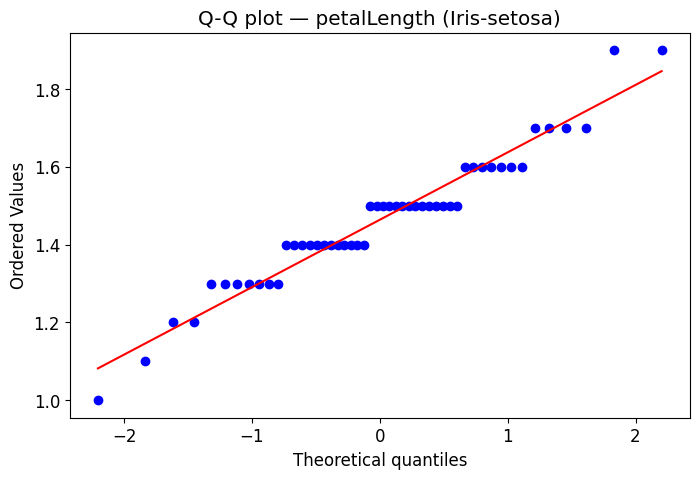

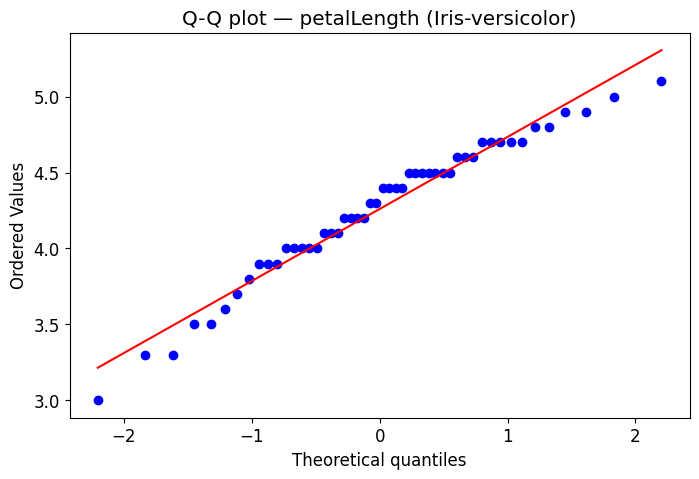

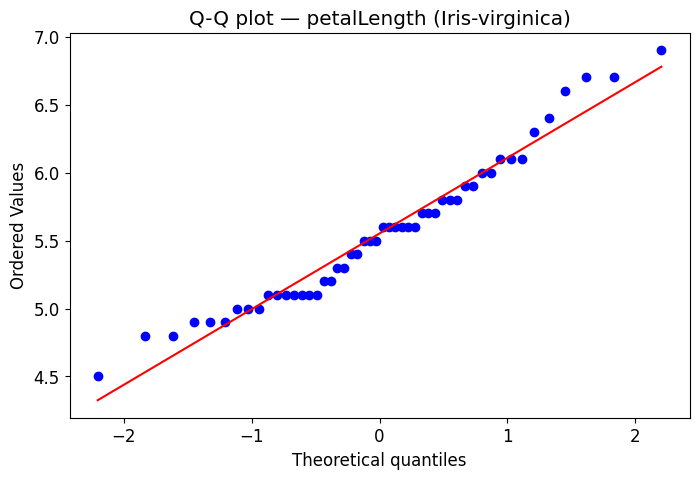

In [23]:
irisDataFrame = pd.read_csv('iris.txt', header=None, names=['sepalLength','sepalWidth','petalLength','petalWidth','class'])
irisDataFrame['petalLength'] = pd.to_numeric(irisDataFrame['petalLength'], errors='coerce')
print('Размер iris:', len(irisDataFrame))
irisDataFrame['class'].unique()

# Для каждой группы проверим нормальность petalLength
for irisClass, groupFrame in irisDataFrame.groupby('class'):
    petalSeries = groupFrame['petalLength'].dropna()
    nGroup = petalSeries.size
    print(f'\n=== {irisClass} ===')
    print('N =', nGroup, 'Mean =', petalSeries.mean(), 'SD =', petalSeries.std(ddof=1))
    if nGroup >= 3:
        shStat, shP = sps.shapiro(petalSeries)
        ksStat, ksP = sps.kstest(petalSeries, 'norm', args=(petalSeries.mean(), petalSeries.std(ddof=1)))
        print('Shapiro-Wilk: statistic =', round(shStat,4), ', p-value =', round(shP,6))
        print('KS (fitted): statistic =', round(ksStat,4), ', p-value =', round(ksP,6))
        print('CI mean =', confidenceIntervalForMean(petalSeries, 0.95))
        print('CI sigma =', confidenceIntervalForSigma(petalSeries, 0.95))
        plt.figure()
        sps.probplot(petalSeries, dist='norm', plot=plt)
        plt.title(f'Q-Q plot — petalLength ({irisClass})')
    else:
        print('Недостаточно данных для тестов')
